[View in Colaboratory](https://colab.research.google.com/github/redcican/BANKSapi/blob/master/1_Regression_Vendor_Payment.ipynb)

# Introduction: State Vendor Payments 

In this contest, the first assignment is to predict the payments of state vendor giving the multiple conditions. 
First, I will describe a comphresensive way to explore the data. After that, this notebook will focus on the regression problem and the whole workflow for a typical machine learning process. 

# Regressioin Problem

First of all, I would like to import all the libraries that will be used for regression problem.

In [0]:
# pandas and numpy for data manipulation
import numpy as np
import pandas as pd

# general libraries for python
import os
from os import path
import string

# matplotlib and seaborn for Visualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# nltk and re for text processing
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer

# scikit-learn and xgboost for machine learning and feature engineering
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from skopt.space import Integer, Categorical, Real
from skopt.utils import use_named_args
from skopt import gp_minimize
import xgboost as xgb
import pickle

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
%matplotlib inline
plt.style.use('fivethirtyeight')
# Set Plot Theme
palette = sns.color_palette('Paired', 10)
# Pandas display options
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Understanding the data

Throughout this notebook, we will work with over 1M rows. Generally, the performance of a machine learning model increases as the amoung of training data increases. When we read in the data, we will tell panda to treat the `MonthTtl` as a date. We will also drop the `Biennium`since it a uniuqe identifier and does not tell us anything about state payments. 

In [0]:
df = pd.read_csv('state_vendor_payment.csv', parse_dates=['MonthTtl']).drop(columns='Biennium')
df['MonthTtl'] = df.MonthTtl.dt.to_period('M')
df.head()

,FY,FYMo,MonthTtl,AgyCode,AgyTtl,Object,SubObject,Recipient,ObjectTtl,SubObjectTtl,Description,Amount
0,2015,23,2015-05,10,Bond Retirement and Interest,C,CC,MONTAGUE DEROSE & ASSOCIATES LLC ...,Personal Service Contracts,Financial Services ...,"The amounts expended for financial services, a...",22237.930
1,2015,23,2015-05,10,Bond Retirement and Interest,C,CB,FOSTER PEPPER PLLC ...,Personal Service Contracts,Legal/Expert Witness Services ...,The amounts expended for legal services and le...,83938.150
2,2015,23,2015-05,10,Bond Retirement and Interest,E,ER,FITCH INC ...,Goods and Services,Other Contractual Services ...,The amounts expended for contractual services ...,35000.000
3,2015,23,2015-05,10,Bond Retirement and Interest,E,ER,MOODYS INVESTORS SERVICE ...,Goods and Services,Other Contractual Services ...,The amounts expended for contractual services ...,68560.990
4,2015,23,2015-05,10,Bond Retirement and Interest,E,EZ,FEDERAL EXPRESS ...,Goods and Services,Other Goods and Services ...,The amounts expended for goods and services ot...,14.620


In [0]:
#df.to_pickle('df_vendor.pkl') 
df = pd.read_pickle('df_vendor.pkl')

### 1.1 Describe Data

From the [offical site](https://data.wa.gov/Procurements-and-Contracts/State-Vendor-Payments/sufm-u7rz) of data we can know there are three types of columns:  
* numerical columns:
    * FY
    * FYMo
    * AgyCode
    * Amount
* categorical columns:
    * Object
    * SubObject
* text columns:
    * AgyTtl
    * Recipient
    * ObjectTtl 
    * SubObjectTtl
    * Description

We can check these information using the `.info()` and `.describe()` methods.

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1519815 entries, 0 to 1524502
Data columns (total 12 columns):
FY              1519815 non-null int64
FYMo            1519815 non-null int64
MonthTtl        1519815 non-null object
AgyCode         1519815 non-null int64
AgyTtl          1519815 non-null object
Object          1519815 non-null object
SubObject       1519815 non-null object
Recipient       1519815 non-null object
ObjectTtl       1519815 non-null object
SubObjectTtl    1519815 non-null object
Description     1519815 non-null object
Amount          1519815 non-null float64
dtypes: float64(1), int64(3), object(8)
memory usage: 150.7+ MB


`df.describe()` is an effective method for catching outliers and anomalies.

In [0]:
df.describe()

,FY,FYMo,AgyCode,Amount
count,1519815.000,1519815.000,1519815.000,1519815.000
mean,2014.486,12.152,285.595,8396.699
std,0.500,6.621,106.161,47437.359
min,2014.000,1.000,10.000,0.010
25%,2014.000,7.000,300.000,152.620
50%,2014.000,12.000,300.000,684.200
75%,2015.000,18.000,300.000,1892.040
max,2015.000,23.000,707.000,999999.750


We can see the distribution of `FY`, `FYMo` and `AgyCode` is quite normal (from 
intuition and common sense). However, the `Amount` seems to have both negative values and extreme values. 

### 1.2 Missing Values

One of the most important steps of exploratory data analysis is finding missing values in the data and determining how to handle them. Missing values have to be filled in before we use a machine learning model and we need to think of the best strategy for filling them in based on the feature. Fortunately, we don't have any missing value!

In [0]:
missing = pd.DataFrame(df.isnull().sum()).rename(columns = {0: 'total'})
missing['percent'] = missing['total'] / len(df)
missing.head(10)

,total,percent
FY,0,0.000
FYMo,0,0.000
MonthTtl,0,0.000
AgyCode,0,0.000
AgyTtl,0,0.000
Object,0,0.000
SubObject,0,0.000
Recipient,0,0.000
ObjectTtl,0,0.000
SubObjectTtl,0,0.000


## 2. Data Exploration and Cleaning  

Data exploration and clearning are crucial steps for data science. I love doing these two steps simulataneously. As I explore the data and find outlying values or errors, I correct them or make a note to follow up later. Data cleaning usually involves domain knowledge, statistical description as son on. 

### 2.1 Check the Target Variable

For a first graphical exploration, we can look at the distribution of `Amount`, the target variable we want to train a model to predict. We will use **seaborn's** `distplot` which shows a kernel density estimate plot and a histogram. Here we plot the top100 amount and their density.

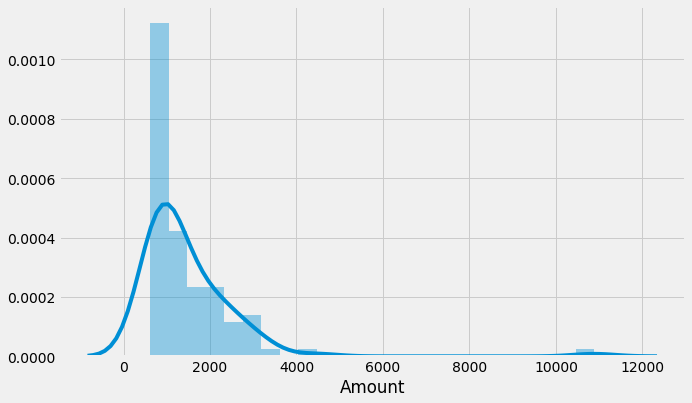

In [0]:
plt.figure(figsize=(10,6))
sns.distplot(df['Amount'].value_counts().nlargest(100))

In [0]:
print("There are {} amounts are negative ".format(len(df[df['Amount'] < 0])))
print("There are {} amounts are equal to $0".format(len(df[df['Amount'] == 0])))
print("There are {} amounts are greater than $1000000".format(len(df[df['Amount'] > 1000000])))

There are 0 amounts are negative 
There are 0 amounts are equal to $0
There are 0 amounts are greater than $1000000


#### 2.1.1 Empirical Cumulative Distribution Plot  
Another plot for showing the distribution of a single variable is the [empirical cumulative distribution function.](https://en.wikipedia.org/wiki/Empirical_distribution_function)This shows the percentile on the y-axis and the variable on the x-axis and gets around some of the issues associated with binning data for histograms of the kernel width of the KDE

In [0]:
def ecdf(x):
    '''
    Define Empirical cumulative distribution function of a variable
    '''
    x = np.sort(x)
    n = len(x)
    
    y = np.arange(1, n+1, 1) / n
    
    return x, y

Text(0.5,1,'ECDF of Amounts')

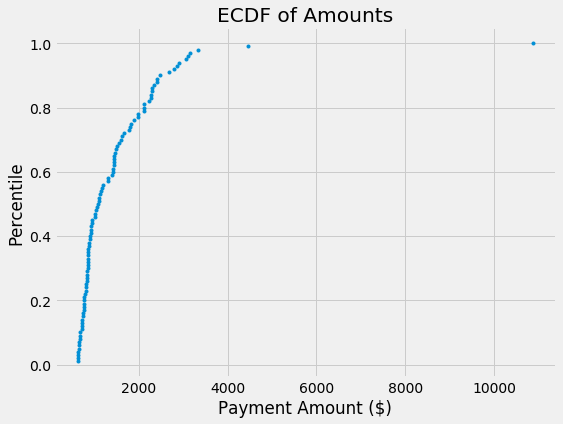

In [0]:
x, y = ecdf(df['Amount'].value_counts().nlargest(100))
plt.figure(figsize=(8,6))
plt.plot(x,y, '.')
plt.ylabel('Percentile')
plt.xlabel('Payment Amount ($)')
plt.title('ECDF of Amounts')

The plot above shows the distribution is heavily right skewed, most of the amounts are below $4000, with a heavy right tail of larger amounts.

### 2.2 Remove the Outliers

Based on the distribution of Amounts and the scale of dataset, I decided to remove any amounts less than 0 and greater than 1000000. 

In [0]:
df = df[df['Amount'].between(left = 0, right = 1000000, inclusive=False)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1519815 entries, 0 to 1524502
Data columns (total 12 columns):
FY              1519815 non-null int64
FYMo            1519815 non-null int64
MonthTtl        1519815 non-null object
AgyCode         1519815 non-null int64
AgyTtl          1519815 non-null object
Object          1519815 non-null object
SubObject       1519815 non-null object
Recipient       1519815 non-null object
ObjectTtl       1519815 non-null object
SubObjectTtl    1519815 non-null object
Description     1519815 non-null object
Amount          1519815 non-null float64
dtypes: float64(1), int64(3), object(8)
memory usage: 150.7+ MB


### 2.3 Explore more details of feature columns

After explore the property of target column, we can focus on more details of the variable columns. 

#### 2.3.1 Numerical columns  
There are 3 numerical feature columns, we can explore them in a similar way!

In [0]:
df['FY'].value_counts()

2014    780970
2015    738845
Name: FY, dtype: int64

There are only two unqiue values of column `FY`, let's check their distribution.

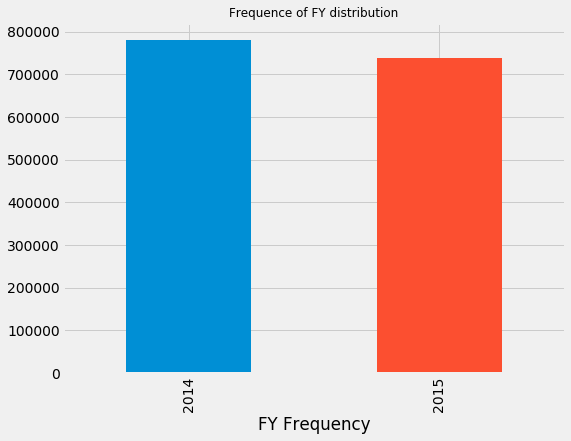

In [0]:
plt.figure(figsize=(8,6))
df['FY'].value_counts().plot(kind='bar')
plt.xlabel('FY Frequency')
plt.title('Frequence of FY distribution', fontsize=12)
plt.show()

In [0]:
# check the unique values of FYMo
len(df['FYMo'].value_counts())

23

The column `FYMo` has 23 unique values. First, we can check their distribution.

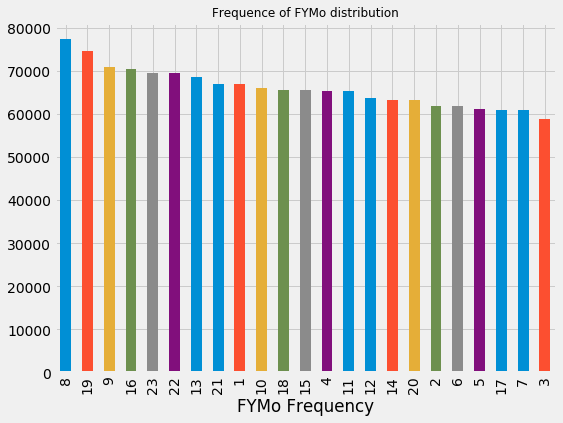

In [0]:
plt.figure(figsize=(8,6))
df['FYMo'].value_counts().plot(kind='bar')
plt.xlabel('FYMo Frequency')
plt.title('Frequence of FYMo distribution', fontsize=12)
plt.show()

We can clearly see that the distribution of `FYMo` is very homogeneous. We can then check the sum of Amounts by `FYMo`

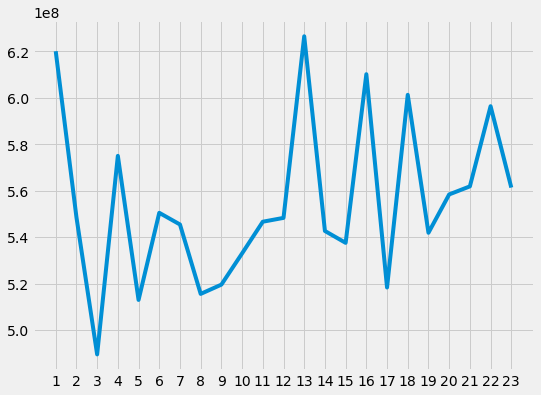

In [0]:
plt.figure(figsize=(8,6))
df_FYMo = df['Amount'].groupby(by=df['FYMo']).sum()
plt.plot(df_FYMo.index, df_FYMo)
plt.xticks(df_FYMo.index);
plt.show()

We can see the distribution of the sum of Amount and which the corresponding values of `FYMo`.  
Next, we explore the column `AgyCode`.

In [0]:
# check the length of Agycode
len(df['AgyCode'].value_counts())

99

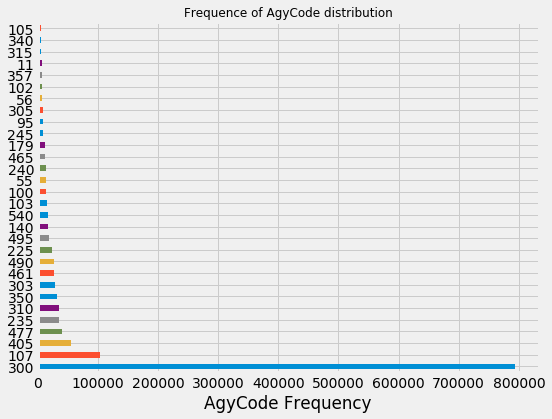

In [0]:
plt.figure(figsize=(8,6))
df['AgyCode'].value_counts().nlargest(30).plot(kind='barh')
plt.xlabel('AgyCode Frequency')
plt.title('Frequence of AgyCode distribution', fontsize=12)
plt.show()

It is very clear that the `300` and `107`occupy a large part of `AgyCode`. The distribution of `AgyCode` is very unbalanced.

#### 2.3.2 Categorical Columns

Let's first check the column `Obejct`. First we can check the number of each label.

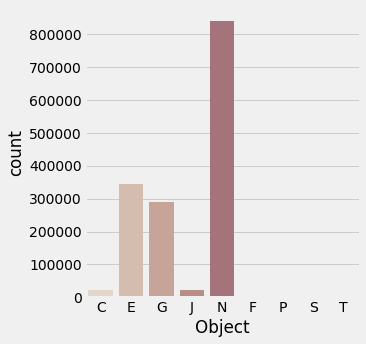

In [0]:
sns.catplot(x="Object", kind="count", palette="ch:.25", data=df)

The `Object` `N`,`E` and `G` have more amounts than any other labels. To show more information about shape of the distribution, we draw the plot as below.

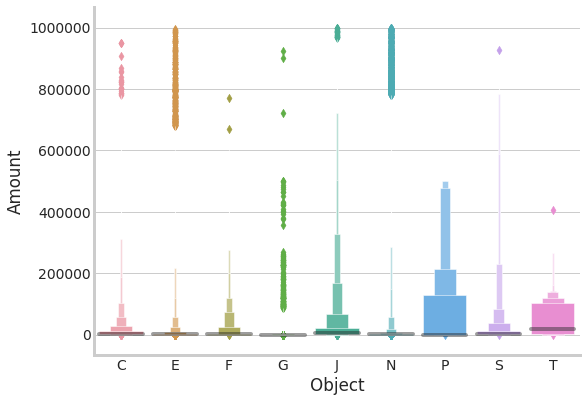

In [0]:
sns.set_style("whitegrid")
g= sns.catplot(x="Object", y="Amount", kind="boxen",
            data=df.sort_values("Object"));
g.fig.set_size_inches(10,6)

The above plot shows more information of `Object` and their corresponding distributions.  
Second, we should have a look of `SubObject`.

In [0]:
# check the length of subobject
len(df['SubObject'].value_counts())

86

We can first check the number of every individual label. We draw the number of top30.

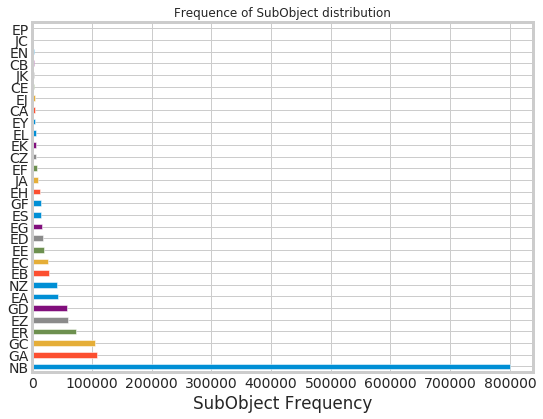

In [0]:
plt.figure(figsize=(8,6))
df['SubObject'].value_counts().nlargest(30).plot(kind='barh')
plt.xlabel('SubObject Frequency')
plt.title('Frequence of SubObject distribution', fontsize=12)
plt.show()

The distribution of `SubObject` is very similar to `AgyCode`. The few of labels occupy the most part of amounts.

#### 2.3.3 Text columns

After having a basic understanding of categocial and numerical features, we should divi into the most challenging part, which is text features. In this dataset, there are 5 text features. `AgyTtl`, `Recipient`,`ObjectTtl` and `SubObjectTtl`are very similar to each other, they are basically a short phrase to describe the payment. However, the feature `Description` is a complete sentence to depict the specific behaviors of payments. I will focus on the feature `Description` and one of the remaining features. 

First, let's take a look at these text features.

In [0]:
pd.set_option('max_colwidth', 500)
df[["AgyTtl","Recipient", "ObjectTtl","SubObjectTtl","Description"]].sample(7)

,AgyTtl,Recipient,ObjectTtl,SubObjectTtl,Description
458623,Health,WALDRON MATTHEW,Travel,Out-Of-State Subsistence & Lodging,"The amounts paid for lodging and/or subsistence expenses incurred while traveling outside the state's boundary on official state business, including lodging taxes."
914769,Social and Health Services,WESTERN WA MEDICAL GROUP,"Grants, Benefits & Client Services",Direct Payments to Providers,"Amounts paid under client service contracts entered into for professional, technical or other services, which will result in the delivery of direct services to individual clients. Client services include such items as medical and mental health treatments, and related transportation; job counseling and training; childcare; foster care; and chore services."
795264,Transportation,TUCCI & SONS INC,Capital Outlays,Highway Construction,"The amounts expended for the construction, improvement, or addition to the state highway system."
901410,Social and Health Services,KOSTENKO BORIS,"Grants, Benefits & Client Services",Direct Payments to Providers,"Amounts paid under client service contracts entered into for professional, technical or other services, which will result in the delivery of direct services to individual clients. Client services include such items as medical and mental health treatments, and related transportation; job counseling and training; childcare; foster care; and chore services."
460150,Corrections,SINCLAIR STEPHEN D,Travel,Other Travel Expenses,"The amounts paid for all other costs incurred while traveling on official state business. Includes, but is not limited to: prospective employee interview expenses; employee relocation expenses; rail, bus, ferry, shuttle, or taxi fares; tolls; rental cars; parking fees; stenographic services; telephone calls; and other miscellaneous expenses."
285065,Licensing,SANITARY SERVICE COMPANY INC,Goods and Services,Utilities,"The amounts expended to heat, cool, and light state owned and/or leased facilities not obtained through the Department of Enterprise Services, where energy costs are not included as part of the monthly lease payments. Also includes the amounts expended for water, sewer, and garbage."
1001877,Transportation Commission,LITT JERALD R,Travel,In-State Subsistence & Lodging,"The amounts paid for lodging and/or subsistence expenses incurred while traveling within the state's boundary on official state business, including lodging taxes."


Obviously, the text features requires further processing.  

In order to process the data set's centerpiece, the `Description` body, I utilized the NLTK package to lowercase, tokenize, and remove stopwords and punctuation. Tokenizing treats each word as its own value, while the other steps gets rid of the noise and irrelevant symbols in the data, standardizing the description for analysis. Upon reviewing the performance of text analysis, I decided to implement the Porter Stemmer on the tokens in order to combine words with tense and plurality deviance.

First, we should download the stopwords from nltk libray.

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    words = [w for w in words if not w in stop_words] #3
    #words = [ps.stem(w) for w in words] #4
    return words

The help function below creates the word cloud visualization function. A word cloud (as the name suggests) is an image that is made up of a mixture of distinct words which may make up a text or book and where the size of each word is proportional to its word frequency in that text. This function’s mathematical processes are hidden, since it does not explicitly state that it determines the frequency occurrence of each word in relation to the entire dictionary of words. Within the function, the Setting Function Parameter section creates the graphic structure using matplotlib. Then the text is formatted, and the word frequency is determined. Finally, the matplotlib structure is filled with words, where the larger the word size, the higher the word occurrence.

In [0]:
stopwords = set(STOPWORDS)
size = (10,8)

def cloud(text, title, stopwords=stopwords, size=size):
    """
    Function to plot WordCloud
    Includes: 
    """
    # Setting figure parameters
    mpl.rcParams['figure.figsize']=(10.0,10.0)
    mpl.rcParams['font.size']=12
    mpl.rcParams['savefig.dpi']=100
    mpl.rcParams['figure.subplot.bottom']=.1 
    
    # Processing Text
    # Redundant when combined with my Preprocessing function
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black',
                          stopwords=stopwords,
                         ).generate(str(text))
    
    # Output Visualization
    fig = plt.figure(figsize=size, dpi=80, facecolor='k',edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=50,color='y')
    plt.tight_layout(pad=0)
    plt.show()
    
# Frequency Calculation [One-Gram]
def wordfreqviz(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    matplotlib.style.use('ggplot')
    rslt.plot.bar(rot=0)

def wordfreq(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    return rslt

We can first draw the wordcloud for `Recipient`.

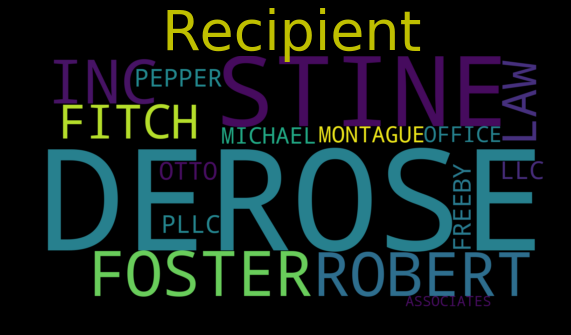

In [0]:
cloud(text= df.Recipient.astype(str).values,
      title="Recipient",
      stopwords= stop_words,
      size = (8,4))

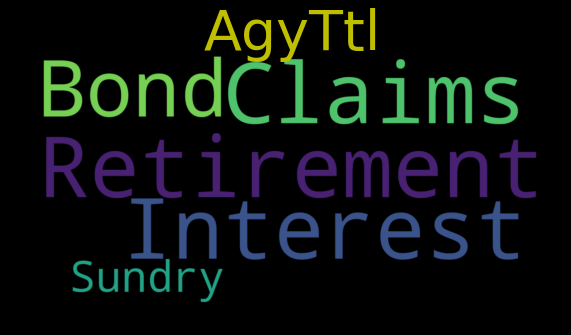

In [0]:
cloud(text= df.AgyTtl.astype(str).values,
      title="AgyTtl",
      stopwords= stop_words,
      size = (8,4))

We can see some key words such as 'MONTAGUE','OFFICE'. Furthermore, we can also create a wordcloud and calculate the words frequency for the `Description`.

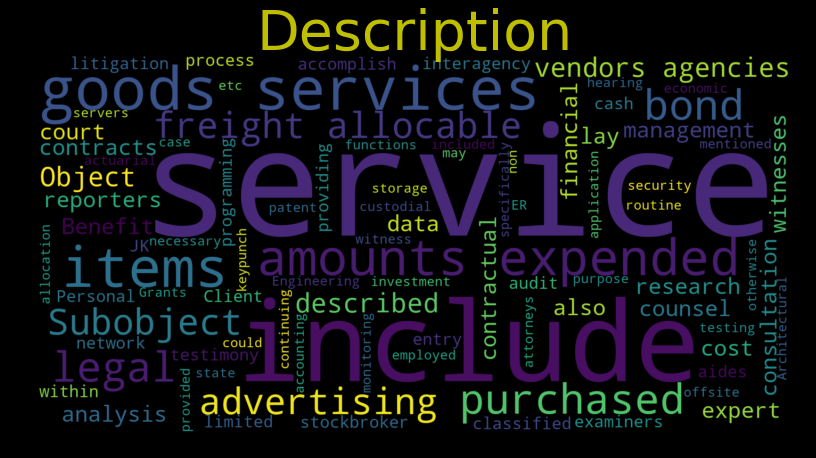

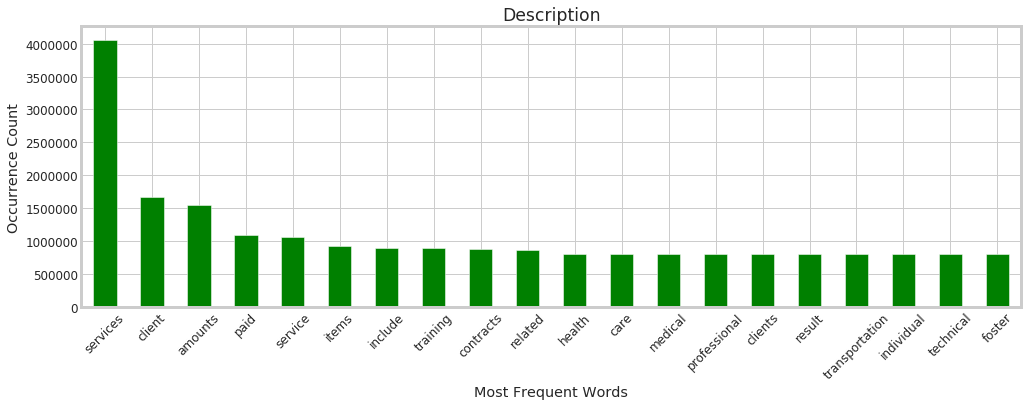

In [0]:
# Description
title ="Description"
temp = df['Description']

# Cloud
cloud(text= temp.values, title=title,stopwords= stop_words)

# Bar Chart
wordfreq(preprocessing(temp),20).plot.bar(rot=45, legend=False,figsize=(15,5), color='g',
                          title= title)
plt.ylabel("Occurrence Count")
plt.xlabel("Most Frequent Words")
plt.show()

Next, we check the length of descriptions and its statistics.

In [0]:
lens =df['Description'].str.len()
lens.mean(), lens.std(), lens.max()

(338.3556320999595, 140.21604025406702, 1030)

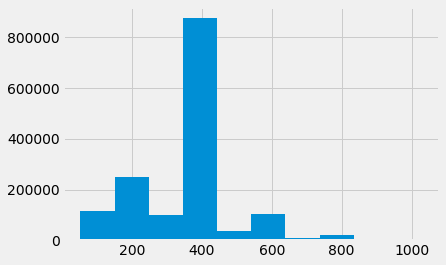

In [0]:
lens.hist()

We can see the most descriptions have a length of 400, but the lengths are quite vary!

Since this dataset involves with Goverment vendor payment, we can see the most frequent words such as 'Services','client','amounts' and so on, which are very reasonable. 

## 3. Feature Engineering 

After a comprehensive exploration of raw dataset, the next step is the process of create features. Feature engineering is the most important step of machine learning. A mdoel can only learn from the featues it is given, for this dataset we have multiple feature types. So the feature engineering is not only important but also necessary!

First of all, let's extract the X and y from original data.

In [0]:
X = df[['MonthTtl','FY','FYMo','AgyCode','AgyTtl','Object','SubObject','Recipient','ObjectTtl','SubObjectTtl','Description']]
y = df['Amount'].values

And then we split our data into training and testing sets since our data dimension is relatively large, I set the test size to 0.1.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)

As mentioned before, there are 3 different types of variables. The first thing I want to do is define how to process my variables. Because we have heterogeneous data, a stardard preprocessing doesn't work quite well. So first thing I am going to do is create a selector transformer that simply returns the one column in the dataset by the key value I pass.  
I made 3 different selectors for either text, categorical or numerica columns. The introduction of **BaseEstimator** can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html), in a similar way, you can find introduction of **TransformerMixin** from [here](http://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html)

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class CategoricalSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    use on categorical columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

So for every single numerical variable, I apply the **StandardScaler** to normalize them. For the following processing, I will use **Pipeline** to simplify the process. Instead of manually running through each of steps, and then tediously repeating them on the test set, we can get a nice, declarative interface where it's easy to see the entire model.

In [0]:
fy =  Pipeline([
                ('selector', NumberSelector(key='FY')),
                ('standard', StandardScaler())
            ])
fymo =  Pipeline([
                ('selector', NumberSelector(key='FYMo')),
                ('standard', StandardScaler())
            ])
agycode =  Pipeline([
                ('selector', NumberSelector(key='AgyCode')),
                ('standard', StandardScaler())
            ])

For every categorical variable, it is a little tricky. Because for the scikit-learn, usually we should first apply **LabelEncoder** after that, we can use **OneHotEncoder**. However, for the [version 0.20](http://scikit-learn.org/dev/whats_new.html),The **OneHotEncoder** estimator was given a nice upgrade to encode columns with string values. I gained the information from this [post](https://medium.com/dunder-data/from-pandas-to-scikit-learn-a-new-exciting-workflow-e88e2271ef62).

In [0]:
obj =  Pipeline([
                ('selector', CategoricalSelector(key='Object')),
                ('labelencoder', OneHotEncoder())
            ])
subobject =  Pipeline([
                ('selector', CategoricalSelector(key='SubObject')),
                ('labelencoder', OneHotEncoder())
            ])

For the text varialbes, I used two different strategies, for the shor phrase variables, `AgyTtl`, `ObjectTtl` and `SubObjectTtl`, I used the **CountVectorizer** to create featurs vecotrs. On the other hand, for `Recipient` and `Description` I used **TF-IDF** (Term Frequency times inverse document frquency) to reduce the weightage of more common words which occus in all document. After that I applied **TruncatedSVD** to maintain the most important features.

In [0]:
agyttl = Pipeline([
                ('selector', TextSelector(key='AgyTtl')),
                ('cvt', CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')
                )])

recipient = Pipeline([
                ('selector', TextSelector(key='Recipient')),
                ('tfidf', TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = stop_words)),
                ('svd', TruncatedSVD(algorithm='randomized', n_components=100)
                )])

objectttl = Pipeline([
                ('selector', TextSelector(key='ObjectTtl')),
            ('cvt', CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
                ngram_range=(1, 3), stop_words = 'english')
            )])

subobjectTtl = Pipeline([
                ('selector', TextSelector(key='SubObjectTtl')),
                ('cvt', CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 3), stop_words = 'english')
                )])

description = Pipeline([
                ('selector', TextSelector(key='Description')),
                ('tfidf', TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = stop_words)),
                ('svd', TruncatedSVD(algorithm='randomized', n_components=300)
                )])

We can use **FeatureUnion** to model these parallel processes. For training set, we should transform and then fit them into pipelines, but for the testing set, we should only transform them.

In [0]:
features = FeatureUnion([('Fy', fy), 
                      ('FYMo', fymo),
                      ('AgyCode', agycode),
                      ('Object', obj),
                      ('SubObject', subobject),
                      ('AgyTtl', agyttl),
                      ('Recipient',recipient),
                      ('ObjectTtl',objectttl),
                      ('SubObjectTtl',subobjectTtl),
                        ('Description',description)])

feature_processing = Pipeline([('features', features)])
X_trans = feature_processing.fit_transform(X_train)

In [0]:
X_test_trans = feature_processing.transform(X_test)

In [0]:
X_trans

<1367833x1207 sparse matrix of type '<class 'numpy.float64'>'
	with 575958493 stored elements in Compressed Sparse Row format>

After feature processing, we got a massive sparse matrix, we first convert the Numpy array into a sparse matrix using `csr_matrix()` function. And then convert them into dense matrix for the next processing!

In [0]:
from scipy.sparse import csr_matrix
X_train_csr = csr_matrix(X_trans)
X_train_dense = X_train_csr.todense()
X_test_csr = csr_matrix(X_test_trans)
X_test_dense = X_test_csr.todense()

In [0]:
X_train_csr

<1367833x1207 sparse matrix of type '<class 'numpy.float64'>'
	with 575958493 stored elements in Compressed Sparse Row format>

Because the feature dimensions are too large, a natural way is to use PCA to reduce the dimensions of features. 

In [0]:
from sklearn.decomposition import PCA
pca = PCA(0.98)

X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca = pca.transform(X_test_dense)

pca.n_components_

77

After PCA, we have only 77 components but contains over 98% explained variance. 

The transformation to PCA is very time consuming, for the reproductive reason, we can use `Pickle` to save those variables locally, and then reload them!

In [0]:
'''
Thd code below is for saving two variables locally. 
'''
pickle.dump(X_train_pca, open('X_train_pca.pkl','wb'),-1)
pickle.dump(X_test_pca, open('X_test_pca.pkl','wb'),-1)

'''
The code below can be uncommented, if you wish to 
load these two variables locally.
'''
#X_train_pca = open('X_train_pca.pkl','rb')
#X_train_pca = pickle.load(X_train_pca)
#X_test_pca = open('X_test_pca.pkl','rb')
#X_test_pca = pickle.load(X_test_pca)

'\nThe code below can be uncommented, if you wish to \nload these two variables locally.\n'

## 4. Machine Learning

Now that We have built a few potentially useful featues, we can use them for machine learning, training a algorithm to predict the target from the features. For such a huge dataset, a highly complex ensemble model is recommonended, here I will use XGBoost.

### 4.1 Using XGBoost

In [0]:
dtrain = xgb.DMatrix(X_train_pca, y_train)
dtest = xgb.DMatrix(X_test_pca, y_test)

'''
The code below is used to save variable locally
'''
dtrain.save_binary('train.buffer')
dtest.save_binary('test.buffer')

In [0]:
'''
The code below is used in case you
want to load the binary file locally.
'''
dtrain = xgb.DMatrix('train.buffer')
dtest = xgb.DMatrix('test.buffer')

[06:24:38] 1367833x77 matrix with 105323141 entries loaded from train.buffer
[06:24:38] 151982x77 matrix with 11702614 entries loaded from test.buffer


Below we first define the parameters fed into xgboost models. To evaluate the performance of the regression model, we define a **xgb_r2_score** manually, r2 score is a optimal metrics for regression problem. 

In [0]:
params = {'tree_method': 'gpu_hist', 'max_depth': 10, 'learning_rate': 0.05,'min_child_weight': 6,
         'n_estimators':100, 'colsample_bytree':0.8, 'objective':'gpu:reg:linear',
         'n_jobs':-1, 'subsample':0.8, 'silent':False, 'eval_metric':"mae"}

watchlist = [(dtrain, 'train'), (dtest, 'valid')]

model = xgb.train(params, dtrain, 1000,watchlist,verbose_eval=10,early_stopping_rounds=50)

prediction = model.predict(dtest)

print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	train-mae:8187.35	valid-mae:7876.12
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 50 rounds.
[10]	train-mae:8155.49	valid-mae:7916.19
[20]	train-mae:8705.72	valid-mae:8532.63
[30]	train-mae:9088.11	valid-mae:8977.01
[40]	train-mae:9312.86	valid-mae:9238.37
[50]	train-mae:9390.32	valid-mae:9361.27
Stopping. Best iteration:
[3]	train-mae:7944.92	valid-mae:7661.21

Best MAE: 7661.21 with 4 rounds


In [0]:
'''
The code below is used to search the hyperparameter
of xgboost by using Gaussian Process
'''
X_train_pca = open('X_train_pca.pkl','rb')
X_train_pca = pickle.load(X_train_pca)
X_test_pca = open('X_test_pca.pkl','rb')
X_test_pca = pickle.load(X_test_pca)

### 4.2 Hyperparameter Optimization Using Gaussian Process

There are many ways to optimize the hyperparameters of xgboost, such as Gridsearch and Randomsearch. I would like to use Bayesian Optimization to find the best hyperparameters. [Scikit-Optimize](https://scikit-optimize.github.io/#skopt.gp_minimize) provides a function `gp_minimize` implenment Bayesian optimization using Gaussian Processes. 

First, we define the search space for Gaussian Processes. These parameters are almost the most important for the xgboost!

In [0]:
space = [Integer(0, 5, name='min_child_weight'),
         Integer(8, 256, name='n_estimators'),
         Integer(0, 20, name='max_depth'),
         Integer(0, 10, name='max_delta_step'),
         Real(10**-2, 10**0,"log-uniform", name='subsample'),
         Real(10**-2, 10**0,"log-uniform", name='colsample_bytree'),
         Real(10**-2, 10**0,"log-uniform", name='colsample_bylevel'),
         Real(10**-2, 10**0,"log-uniform", name='learning_rate'),]

Next, we define a xgboost estimator, here in order to utilize the power of GPU, I difine the `objective` and `tree_method` to accelerate the training process, since this process can take much time without GPU. In case you don't have a GPU available, just modify the `gpu:reg:linear` to `reg:linear` and `gpu_hist` to `auto`.

In [0]:
estimator = xgb.XGBRegressor(
        n_jobs = -1,
        objective = 'gpu:reg:linear',
        eval_metric = 'mae',
        silent=0,
        tree_method='gpu_hist')

This decorator allows our objective function to receive a the parameters as keyword arguments. This is particularly convenient when you want to set scikit-learn, here we use **cross_val_score** from scikit-learn to evaluate the performance of our estimator.

In [0]:
@use_named_args(space)
def objective(**params):
    estimator.set_params(**params)
    return -np.mean(cross_val_score(estimator, X_train_pca, y_train, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error'))

Because the size of dataset, this process can take much time than expected, so I only use 20 iterations!

In [0]:
reg_gp = gp_minimize(objective, space, verbose=True, n_jobs=-1, n_calls=20)

print('best score: {}'.format(reg_gp.fun))

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 62.0855
Function value obtained: 8426.9477
Current minimum: 8426.9477
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 165.4057
Function value obtained: 8404.8981
Current minimum: 8404.8981
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 48.0012
Function value obtained: 8423.3537
Current minimum: 8404.8981
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 100.6772
Function value obtained: 8409.9311
Current minimum: 8404.8981
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 164.8862
Function value obtained: 8261.1210
Current minimum: 8261.12

We can now print our parameters out!

In [0]:
print("""Best parameters:
- min_child_weight=%d
- n_estimators=%d
- max_depth=%d
- max_delta_step=%d
- subsample=%.3f
- colsample_bytree=%.3f
- colsample_bylevel=%.3f
- learning_rate=%.4f""" % (reg_gp.x[0], reg_gp.x[1], 
                            reg_gp.x[2], reg_gp.x[3], 
                            reg_gp.x[4], reg_gp.x[5],
                          reg_gp.x[6], reg_gp.x[7]))

Best parameters:
- min_child_weight=3
- n_estimators=157
- max_depth=1
- max_delta_step=10
- subsample=0.474
- colsample_bytree=0.102
- colsample_bylevel=0.659
- learning_rate=0.4620


The plot below shows the convergence of Gaussian Process, we can see that the evaluation metric decreases with the increasing of iterations.

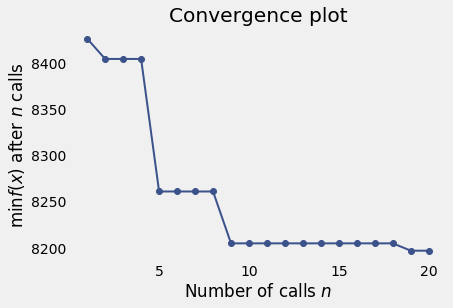

In [0]:
from skopt.plots import plot_convergence

plot_convergence(reg_gp)

After having the optimized parameters, we can retrain our model.

In [0]:
params = {'tree_method': 'gpu_hist', 'max_depth': 1, 'learning_rate': 0.4620,'min_child_weight': 3,
         'n_estimators':157, 'colsample_bytree':0.102, 'objective':'gpu:reg:linear','max_delta_step':10,
         'n_jobs':-1, 'subsample':0.474, 'colsample_bylevel':0.659,'silent':False, 'eval_metric':"mae"}

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(dtrain, 'train'), (dtest, 'valid')]

opti_model = xgb.train(params, dtrain, 1000,watchlist,verbose_eval=10,early_stopping_rounds=50)

prediction = opti_model.predict(dtest)

print("Best MAE: {:.2f} with {} rounds".format(
                 opti_model.best_score,
                 opti_model.best_iteration+1))

[0]	train-mae:8423.45	valid-mae:8105.74
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 50 rounds.
[10]	train-mae:8384.36	valid-mae:8066.73
[20]	train-mae:8353.17	valid-mae:8035.63
[30]	train-mae:8327.19	valid-mae:8009.81
[40]	train-mae:8305.01	valid-mae:7987.87
[50]	train-mae:8285.99	valid-mae:7969.1
[60]	train-mae:8269.29	valid-mae:7952.64
[70]	train-mae:8254.62	valid-mae:7938.22
[80]	train-mae:8242.33	valid-mae:7926.2
[90]	train-mae:8231.97	valid-mae:7916.06
[100]	train-mae:8222.48	valid-mae:7906.75
[110]	train-mae:8214.54	valid-mae:7898.96
[120]	train-mae:8208.5	valid-mae:7893.07
[130]	train-mae:8203.22	valid-mae:7887.93
[140]	train-mae:8200.45	valid-mae:7885.26
[150]	train-mae:8196.83	valid-mae:7881.73
[160]	train-mae:8197.08	valid-mae:7882.06
[170]	train-mae:8198.67	valid-mae:7883.73
[180]	train-mae:8199.15	valid-mae:7884.22
[190]	train-mae:8202.3	valid-mae:7887.38
Stopping. Best iteration:
[149]	

Compare to our first model, we have increased the performance of our model both on training and testing set. So I decided to use this model to predict the final Amouts!

In [0]:
result = pd.DataFrame({'predicttion': prediction[:10], 'actual': y_test[:10]})
result

,actual,predicttion
0,1150.500,7731.862
1,1238.990,1498.230
2,441.810,1364.226
3,4548.350,2476.102
4,780.000,1875.015
5,10100.360,10815.380
6,625.860,1973.059
7,1341.000,4591.785
8,2.660,2440.937
9,378.760,6366.144


## 5. Final Thought

It turns out, the performance of this model isn't quite satisfactory. There are many ways that I can keep improving the final performance. An intuitive way is to use more iterations to search suitable parameters using Gaussian Process. On the other hand, such a huge dataset can also fed into a Deep Learning Algorithm, such as MLP (Multilayer perceptron). A handy way is stack more models to a complex ensemble models!